# Default nitrogen-vacancy model and multiqubit tutorial

<span style="font-variant: small-caps;">Simphony</span> is a Python package designed for **simulating the spin dynamics** of point defects, particularly the nitrogen-vacancy (NV) center, which is surrounded by nuclear spins and utilized as a **central-spin quantum register**.

The main goal of this tutorial is to introduce the **predefined NV center model** and demonstrate <span style='font-variant: small-caps;'>Simphony</span>'s **multiqubit capabilities**. We illustrate this by simulating a phase gate acting on three nuclear spins, with the electron spin serving as an ancilla.

## Import the packages

We import <span style="font-variant: small-caps;">Simphony</span> using the CPU as the default backend:

In [1]:
import numpy as np

import simphony
simphony.Config.set_matplotlib_format('retina')

from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate

## Default NV model

<span style="font-variant: small-caps;">Simphony</span> provides a built-in function to construct a default NV center model. Using the `default_nv_model()` function, you can **define a model containing a single NV electron spin**. A **nitrogen nuclear spin** can be added by specifying its **isotope number** through the `nitrogen_isotope` argument, which must be `14`, `15`, or `None`. Additional **carbon-13 nuclear spins** can be included using the `carbon_atom_indices` argument, which must be a **list of tuples**.  

Each tuple $(n_1, n_2, n_3, n_4)$ defines the position of a carbon atom as:

$$
\text{carbon atom position} = n_1 \cdot \mathbf{a}_1 + n_2 \cdot \mathbf{a}_2 + n_3 \cdot \mathbf{a}_3 + n_4 \cdot \boldsymbol{\tau},
$$

where $\mathbf{a}_1$, $\mathbf{a}_2$, and $\mathbf{a}_3$ are the primitive lattice vectors, and $\mathbf{0}$ and $\boldsymbol{\tau}$ are the positions of the carbon atoms inside the primitive cell. The indices $n_1$, $n_2$, $n_3$ are integers, and $n_4$ is either $0$ or $1$. Our convention is:

$$
\begin{aligned}
\mathbf{a}_1 &= a_\text{CC}\cdot \left( 0, \frac{2\sqrt{2}}{3}, \frac{4}{3} \right), \\
\mathbf{a}_2 &= a_\text{CC}\cdot \left( -\frac{\sqrt{6}}{3}, -\frac{\sqrt{2}}{3}, \frac{4}{3} \right), \\
\mathbf{a}_3 &= a_\text{CC}\cdot \left( \frac{\sqrt{6}}{3}, -\frac{\sqrt{2}}{3}, \frac{4}{3} \right), \\
\boldsymbol{\tau} &= \frac{\mathbf{a}_1 + \mathbf{a}_2 + \mathbf{a}_3}{4} = a_\text{CC}\cdot (0, 0, 1),
\end{aligned}
$$

where $a_\text{CC} = 0.1545\ \text{nm}$ is the carbon–carbon distance. The nitrogen occupies the $\boldsymbol{\tau}$ position, while the missing carbon atom (vacancy) corresponds to the $\mathbf{0}$ lattice point.

The Hamiltonian describes the default NV model (*note that our convention for nuclear spin gyromagnetic ratios is different from the standard convention*):

$$
H =
\underbrace{\gamma_{e} \mathbf{B} \cdot \mathbf{S} + D S_z^2}_{\text{electron}}
+
\underbrace{\gamma_{N} \mathbf{B} \cdot \mathbf{I}_{N} + P I_{N,z}^2 + \mathbf{S} \cdot \mathbf{A}_{N} \cdot \mathbf{I}_{N}}_{\text{nitrogen}}
+
\underbrace{\sum_{i} \left( \gamma_{C} \mathbf{B} \cdot \mathbf{I}_{C}^{(i)} + \mathbf{S} \cdot \mathbf{A}_{C}^{(i)} \cdot \mathbf{I}_{C}^{(i)} \right)}_{\text{carbon(s)}}.
$$

| Spin                        | Parameter               | Symbol                 | Value                               |
|------------------------------|------------------------|-----------------------|-------------------------------------|
| Electron (S=1)               | Gyromagnetic ratio      | γ_e                   | 28.0331 GHz/T [1]                   |
|                              | Zero-field splitting    | D                     | 2.872 GHz [1]                        |
| Nitrogen-14 (I=1)            | Gyromagnetic ratio      | γ_N                   | -3.07771 MHz/T [2]                  |
|                              | Quadrupole splitting    | P                     | -5.01 MHz [1]                        |
|                              | Hyperfine perpendicular | A_N⊥                  | -2.70 MHz [1]                        |
|                              | Hyperfine parallel      | A_N∥                  | -2.14 MHz [1]                        |
| Nitrogen-15 (I=1/2)          | Gyromagnetic ratio      | γ_N                   | 4.31727 MHz/T [2]                   |
|                              | Hyperfine perpendicular | A_N⊥                  | 3.65 MHz [1]                         |
|                              | Hyperfine parallel      | A_N∥                  | 3.03 MHz [1]                         |
| Carbon-13 (I=1/2)            | Gyromagnetic ratio      | γ_C                   | -10.7084 MHz/T [2]                  |

**References:**

[1] Felton et al., Phys. Rev. B 79, 075203 (2009)  
[2] CRC Handbook of Chemistry and Physics, sec. 11-4 (97th edition)



A simple spin system consisting of **an NV electron spin**, a **$^{14}\text{N}$ nuclear spin**, and **two $^{13}\text{C}$ nuclear spins** can be defined as:


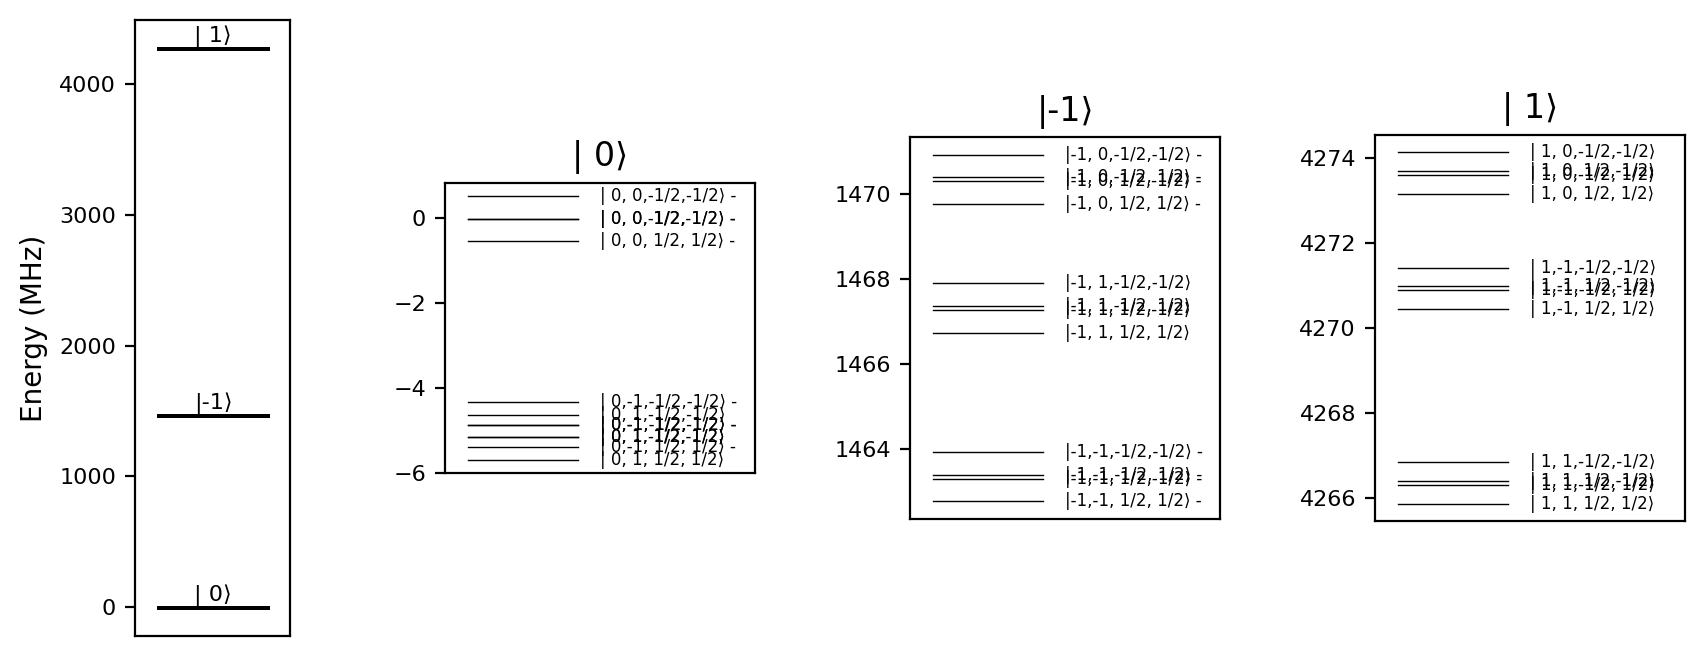

In [2]:
model = simphony.default_nv_model(nitrogen_isotope=14,
                                  static_field_strength=0.05,
                                  carbon_atom_indices=[(1,1,1,0), (2,-3,4,1)],
                                  electron_spin_state='0',
                                  nuclear_spin_state='1')
model.plot_levels()

The **rotating frame** is defined as follows:

* The rotating frame frequency of the electron spin is set to its qubit splitting (transition frequency), conditioned on the nuclear spins being in state $\ket{1}$.
* The rotating frame frequencies of all nuclear spins are set to their respective qubit splittings, assuming the electron spin is in state $\ket{0}$ and the other nuclear spins are in state $\ket{1}$.

The spins included in the model are:

In [3]:
model.spins

[Spin(dimension=3, name='e', qubit_subspace=(0, -1), gyromagnetic_ratio=28033.1, zero_field_splitting=2872.0, local_quasistatic_noise=[0, 0, 0]),
 Spin(dimension=3, name='N', qubit_subspace=(0, -1), gyromagnetic_ratio=-3.07771, zero_field_splitting=-5.01, local_quasistatic_noise=[0, 0, 0]),
 Spin(dimension=2, name='C1', qubit_subspace=(-0.5, 0.5), gyromagnetic_ratio=-10.7084, zero_field_splitting=0.0, local_quasistatic_noise=[0, 0, 0]),
 Spin(dimension=2, name='C2', qubit_subspace=(-0.5, 0.5), gyromagnetic_ratio=-10.7084, zero_field_splitting=0.0, local_quasistatic_noise=[0, 0, 0])]

By default, the **hyperfine interactions between the electron spin and the nuclear spins** are taken from the [hyperfine dataset provided by Viktor Ivády's group](https://ivadygroup.elte.hu/hyperfine/nv/index.html):

In [4]:
model.interactions

[Interaction(spin_name_1='e', spin_name_2='N', tensor=[[-2.7, 0, 0], [0, -2.7, 0], [0, 0, -2.14]]),
 Interaction(spin_name_1='e', spin_name_2='C1', tensor=[[-0.067270283415, 3.70794550132416e-07, -7.27906701892158e-08], [3.70794550132416e-07, -0.0672701293583333, -7.09176246990739e-07], [-7.27906701892158e-08, -7.09176246990739e-07, 0.0958844127833333]]),
 Interaction(spin_name_1='e', spin_name_2='C2', tensor=[[0.0050591293382, 0.0038067421256854, 0.0154034100176021], [0.0038067421256854, -0.0096116264187333, 0.003696458093473], [0.0154034100176021, 0.003696458093473, 0.0045524970785333]])]

By default, a **microwave (MW)** and a **radio-fequency (RF) field** are added to the model. Both driving fields point to the x-direction:

In [5]:
model.driving_fields

[DrivingField(name='MW_x', direction=[1. 0. 0.]),
 DrivingField(name='RF_x', direction=[1. 0. 0.])]

## Phase gate

The phase gate is implemented using a weak electron spin resonance (ESR) pulse. This pulse **rotates the electron spin by $2\pi$ if and only if the nuclear spins are in their qubit state $\ket{1}$**. The pulse frequency must match the electron spin splitting when all nuclear spins are in state $\ket{1}$, which corresponds to the quantum number `-1` for the nitrogen and `1/2` for the carbon nuclear spins:

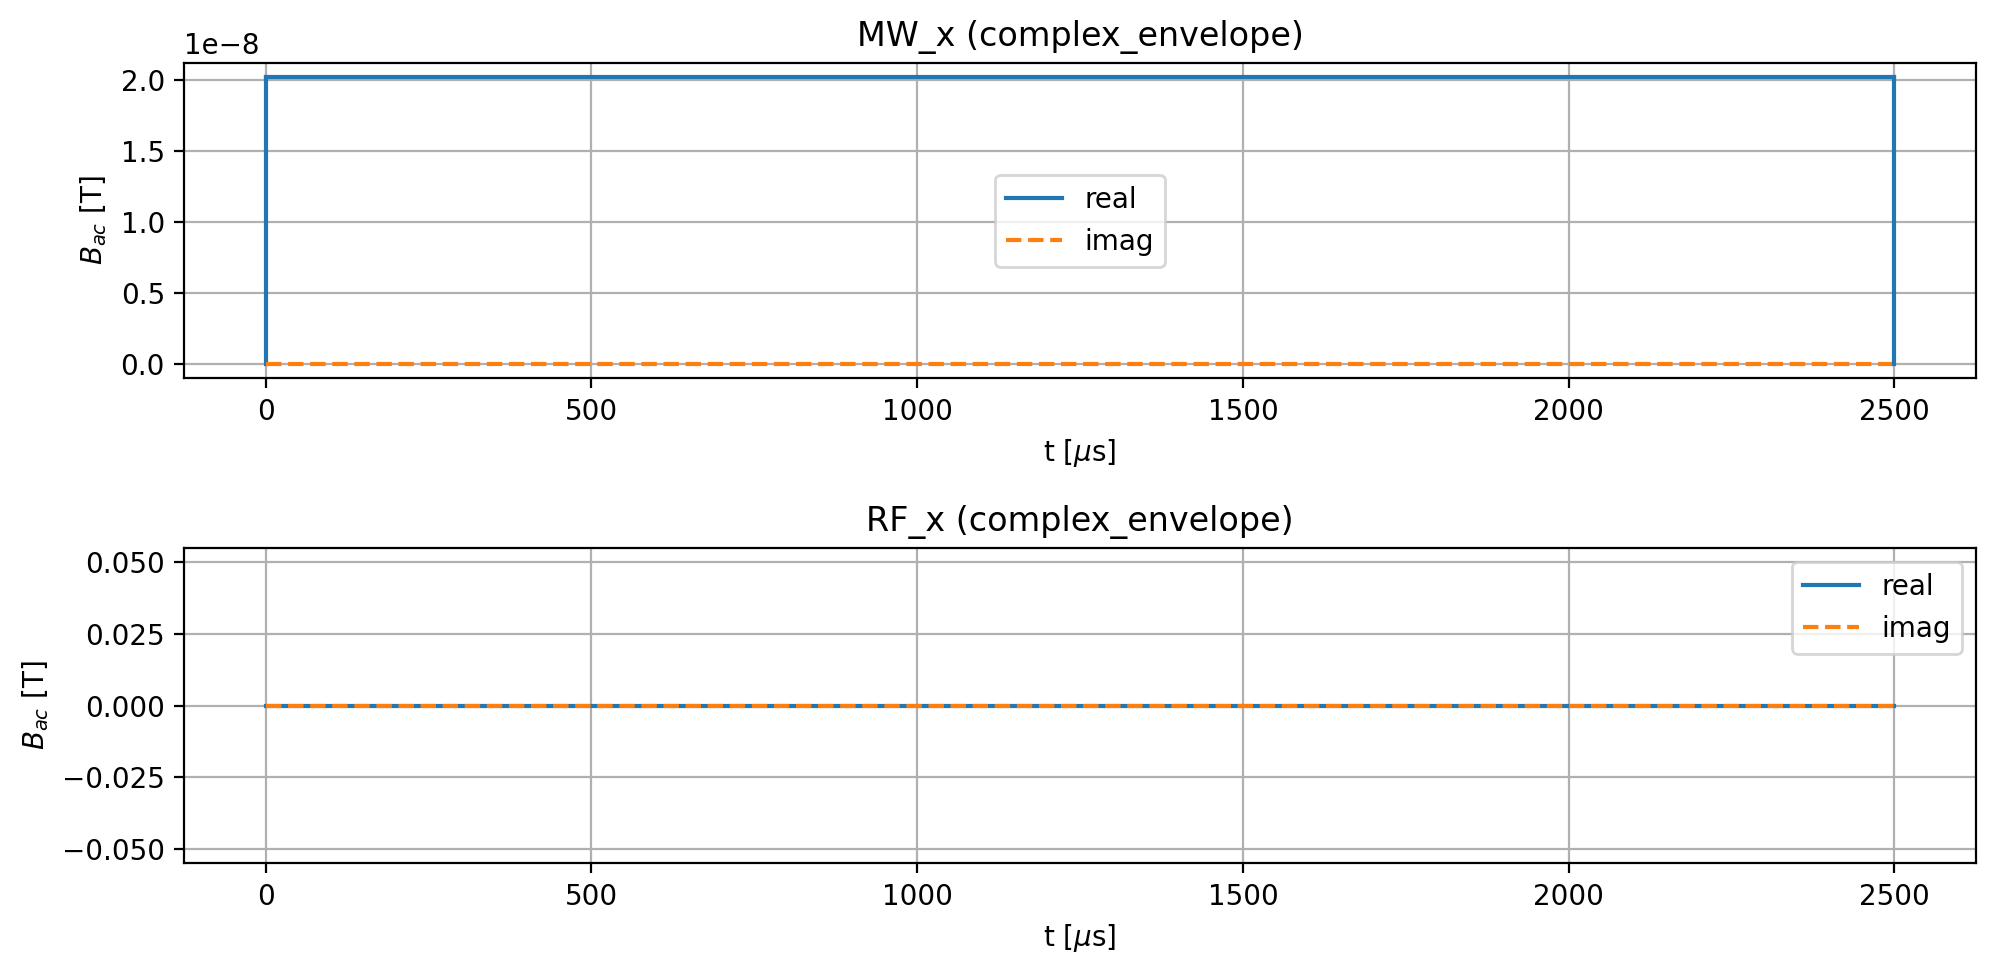

In [6]:
duration = 2500
frequency = model.splitting_qubit('e', rest_quantum_nums={'N': -1, 'C1': 1/2, 'C2': 1/2})
phase = 0
angle = 2 * np.pi
period_time = 2 * np.pi / angle * duration
amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name='MW_x',
                                             period_time=period_time,
                                             spin_name='e',
                                             rest_quantum_nums={'N': -1, 'C1': 1/2, 'C2': 1/2})

model.remove_all_pulses()
model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude,
                                                frequency=frequency,
                                                phase=phase,
                                                duration=duration)


model.plot_driving_fields(function='complex_envelope')

Run the simulation for the defined pulse:

In [7]:
result = model.simulate_time_evolution(verbose=True)

start = 0.0
end = 2500.0
solver_method = jax_expm
number of simulated driving terms = 1
number of simulated noise terms = 0
---------------------------------------------------------------------------
simulate time segment [0, 2500] with step size 2.724e-06 (type: single_sine_wave)


To examine the effect of the pulse, we define an initial state. The electron spin undergoes a $2\pi$ rotation **only when the nuclear spins are in their qubit state $\ket{1}$**, which corresponds to the quantum number `-1` for the nitrogen and `1/2` for the carbon nuclear spins. If we change `-1` to `0` for `N`, or `1/2` to `-1/2` for either `C1` or `C2`, the rotation should no longer occur:

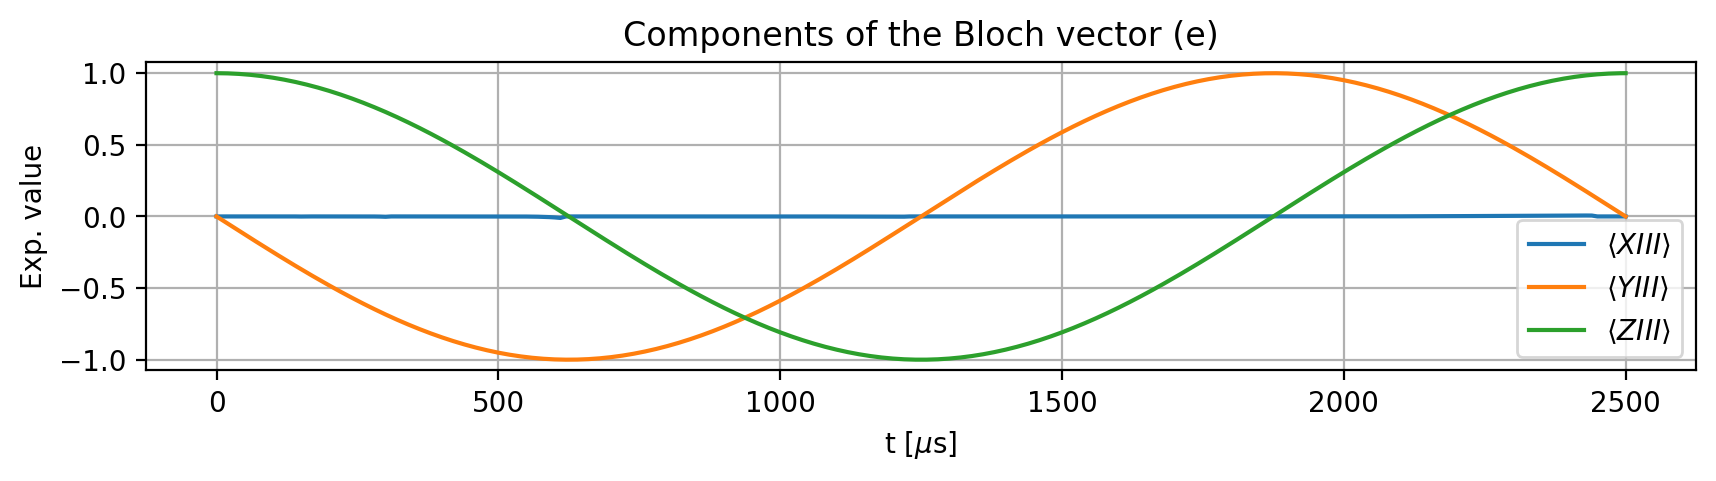

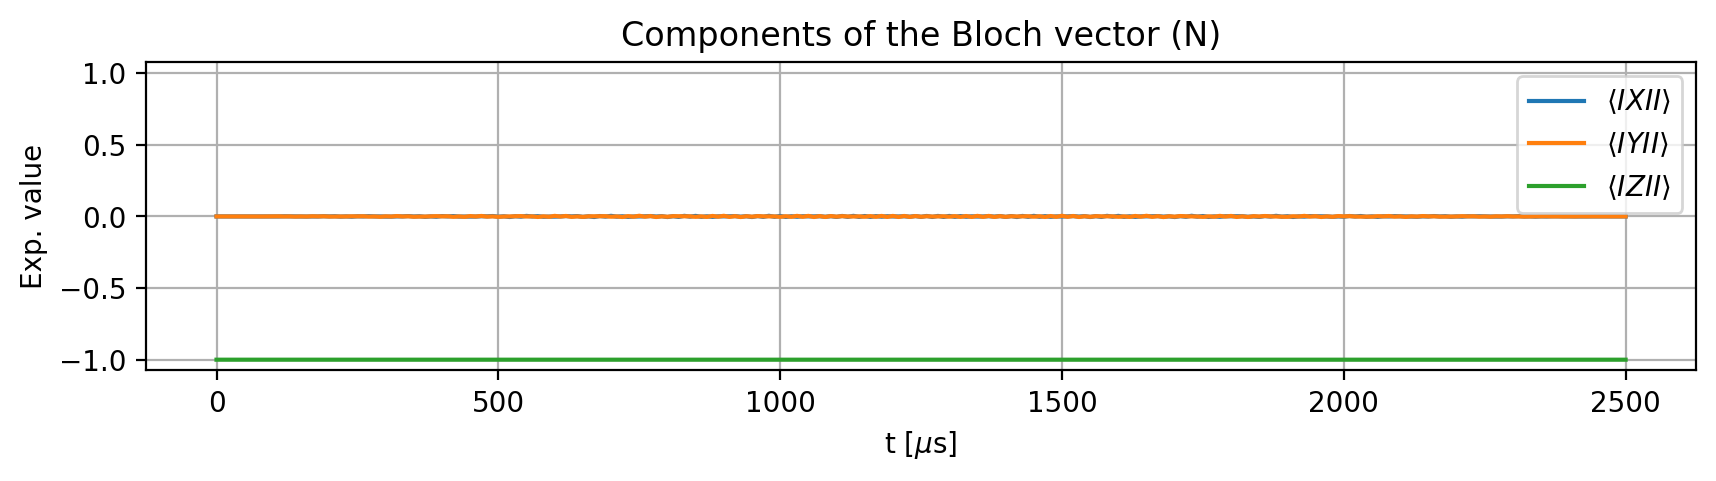

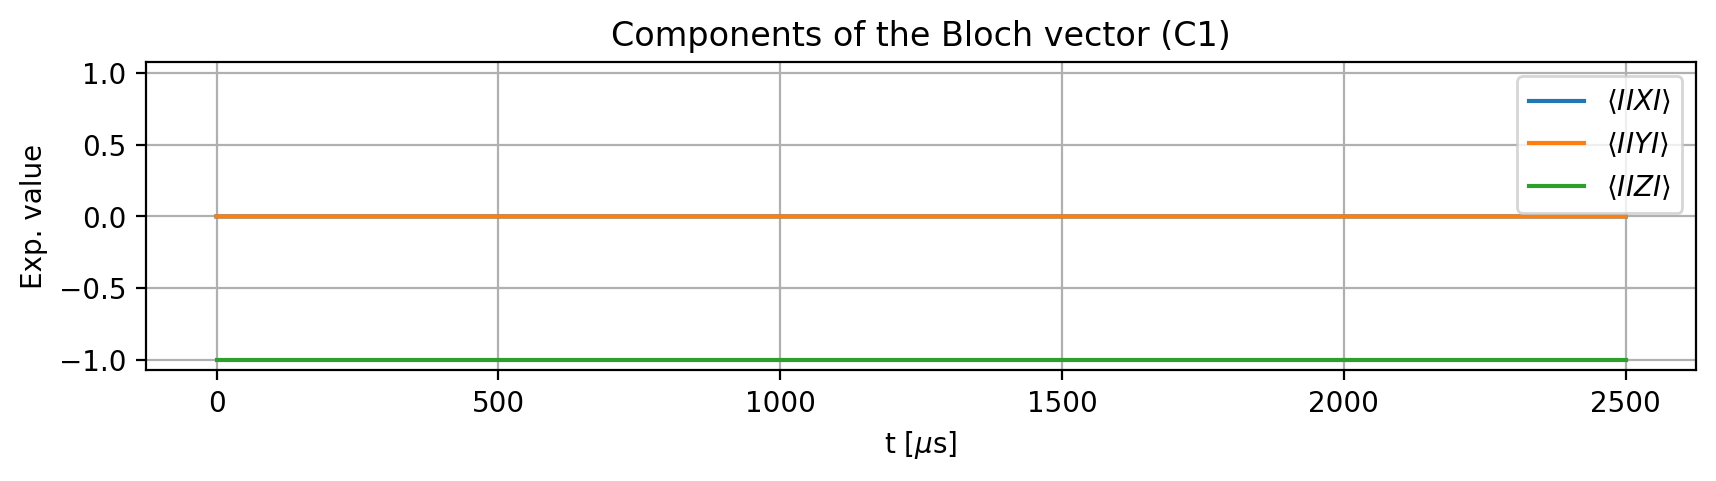

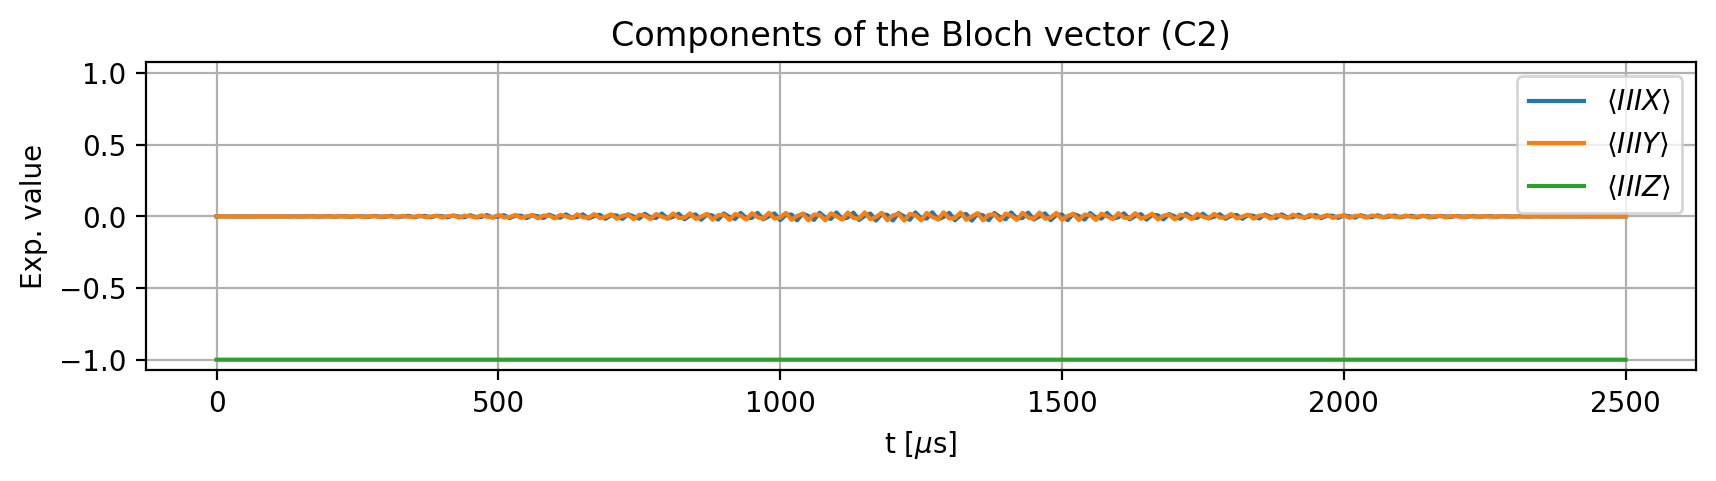

In [8]:
result.initial_state = model.productstate({'e': 0, 'N': -1, 'C1': 1/2, 'C2': 1/2})
result.plot_Bloch_vectors()

The implemented operation corresponds to a conditional $\text{RX}(2\pi)$ gate:

In [9]:
qc = QuantumCircuit(4)
qc.append(RXGate(angle).control(3, ctrl_state='111'), [1, 2, 3, 0])
qc.draw()

┌────────┐
q_0: ┤ Rx(2π) ├
     └───┬────┘
q_1: ────■─────
         │     
q_2: ────■─────
         │     
q_3: ────■─────

The average gate fidelity over the qubit subspace of all spins is:

In [10]:
result.ideal = qc
result.average_gate_fidelity()

np.float64(0.2548069589626061)

The reduced fidelity arises from the hyperfine interaction, which causes the nuclear spin to accumulate different phases depending on the electron spin state. In the rotating frame, only a single electron spin manifold can be effectively addressed. To circumvent this issue and achieve phase control, the **electron spin is typically used as an ancilla**, initialized in the $\ket{0}$ state. In this case, the pulse implements a **phase gate**, or equivalently, a **symmetric CCZ gate** on the nuclear spins.

If we calculate the average gate fidelity over the nuclear spin subspace only, treating the electron as an ancilla fixed in the state $\ket{0}$, we obtain:

In [11]:
result.average_gate_fidelity(ancilla_state={'e': '0'})

np.float64(0.9983694884638518)